# Step 1. 데이터셋 내려받기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

## 1) 데이터 로드 및 확인

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [3]:
# 저장 경로 확인
data_dir

PosixPath('/aiffel/.keras/datasets/flower_photos')

In [4]:
# 사진 수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


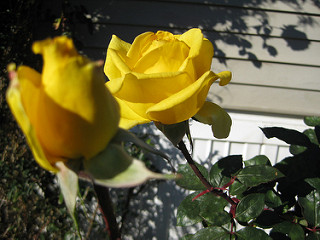

In [5]:
# 이미지 확인
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

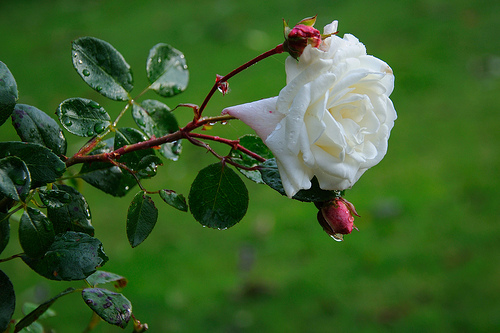

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## 2) 데이터 세트 구성

In [7]:
# 훈련 데이터 80%, 검증 데이터 10%, 평가 데이터 10% 분배
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name = 'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir=data_dir,
    download=True,
    with_info=True,
    as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/.keras/datasets/flower_photos/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [8]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


# Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

## 1) 이미지 크기 확인 및 변형

In [9]:
import matplotlib.pyplot as plt

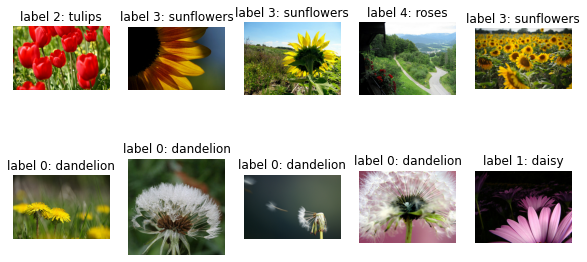

In [10]:
# 원본 이미지 크기 확인
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [11]:
# 이미지 변형을 위한 함수 작성
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [12]:
# 이미지 변형
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


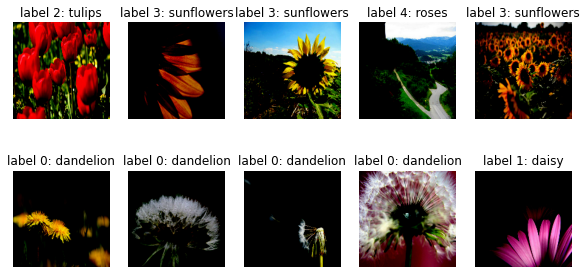

In [13]:
# 이미지 변형 결과 확인
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 2) 배치 데이터 준비

In [14]:
batch_size = 32
shuffle = 1000

In [15]:
train_batches = train.shuffle(shuffle).batch(batch_size)
validation_batches = validation.shuffle(shuffle).batch(batch_size)
test_batches = test.batch(batch_size)

# Step 3. 모델 설계하기

- 모델 설계 및 학습은 두 부분으로 구성해서 성능 테스트
- 하나는 기본적인 CNN 구성 및 학습(step 3~5)
- 다른 하나는 VGG16을 이용한 모델 구성 및 학습(set 6)

In [16]:
from tensorflow import keras

In [17]:
# 모델 구성
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

# Step 4. 모델 학습

In [19]:
# 컴파일(옵티마이저: RMSprop, 학습률 0.0001)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics='accuracy')

In [20]:
history = model.fit(train_batches, 
                    epochs=10, 
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 11s 63ms/step - loss: 1.3486 - accuracy: 0.4390 - val_loss: 1.0851 - val_accuracy: 0.5749
Epoch 2/10
92/92 [==============================] - 5s 44ms/step - loss: 1.0460 - accuracy: 0.5620 - val_loss: 1.2178 - val_accuracy: 0.4877
Epoch 3/10
92/92 [==============================] - 4s 43ms/step - loss: 0.9236 - accuracy: 0.6448 - val_loss: 0.9348 - val_accuracy: 0.6376
Epoch 4/10
92/92 [==============================] - 4s 43ms/step - loss: 0.8122 - accuracy: 0.6907 - val_loss: 0.8929 - val_accuracy: 0.6730
Epoch 5/10
92/92 [==============================] - 4s 43ms/step - loss: 0.7077 - accuracy: 0.7394 - val_loss: 0.9367 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 5s 44ms/step - loss: 0.6150 - accuracy: 0.7813 - val_loss: 1.0714 - val_accuracy: 0.6076
Epoch 7/10
92/92 [==============================] - 4s 43ms/step - loss: 0.5381 - accuracy: 0.8072 - val_loss: 1.1498 - val_accuracy: 0.5913
Epoch 8/10
9

# Step 5. 모델 성능 평가하기

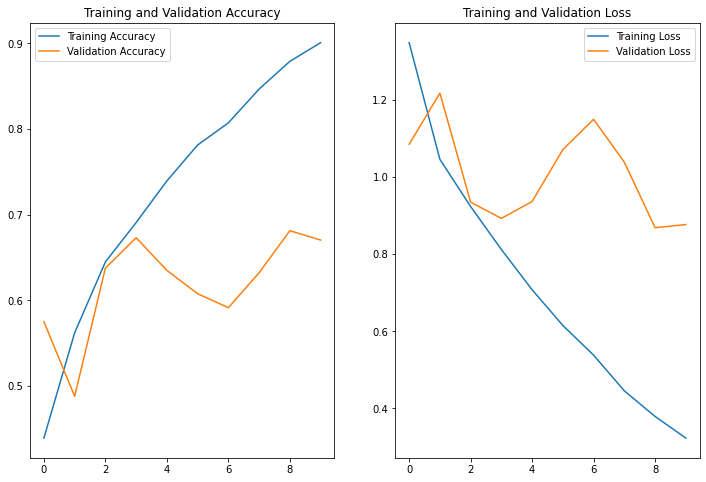

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- 훈련 데이터는 에폭마다 일정하게 증거하나, 검증 데이터는 변화의 폭이 불안정함 
- 과데적합 된 것으로 보임

In [22]:
# 1개 배치 데이터에 대한 예측값 확인
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

print(predictions.shape)
predictions

(32, 5)


array([[1.04356406e-03, 5.07213222e-03, 6.29917383e-01, 3.54628786e-02,
        3.28504026e-01],
       [8.15255344e-01, 1.78820148e-01, 4.81996126e-03, 5.74726218e-05,
        1.04705559e-03],
       [8.63307953e-01, 2.00310200e-02, 7.56957605e-02, 4.06694412e-02,
        2.95802543e-04],
       [2.96895877e-02, 6.79425970e-02, 6.12375677e-01, 3.03075230e-03,
        2.86961406e-01],
       [6.96933866e-01, 9.49341133e-02, 5.32907844e-02, 3.05279456e-02,
        1.24313243e-01],
       [2.90309280e-01, 2.97901273e-01, 1.52711421e-01, 1.12065105e-02,
        2.47871503e-01],
       [1.10869500e-04, 9.72345378e-03, 9.80045915e-01, 1.83486118e-04,
        9.93619394e-03],
       [4.44519110e-02, 2.25653470e-01, 2.41143629e-01, 9.28944200e-02,
        3.95856589e-01],
       [9.11749378e-02, 8.68503994e-05, 3.22366506e-02, 8.76374900e-01,
        1.26706393e-04],
       [9.74320114e-01, 2.30324008e-02, 6.56257325e-04, 1.67614809e-04,
        1.82360911e-03],
       [9.79128182e-01, 9.4128

In [23]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 1, 2, 4, 3, 0, 0, 0, 3, 4, 4, 3, 2, 0, 1, 4, 2, 0,
       2, 0, 1, 0, 2, 2, 2, 1, 0, 4])

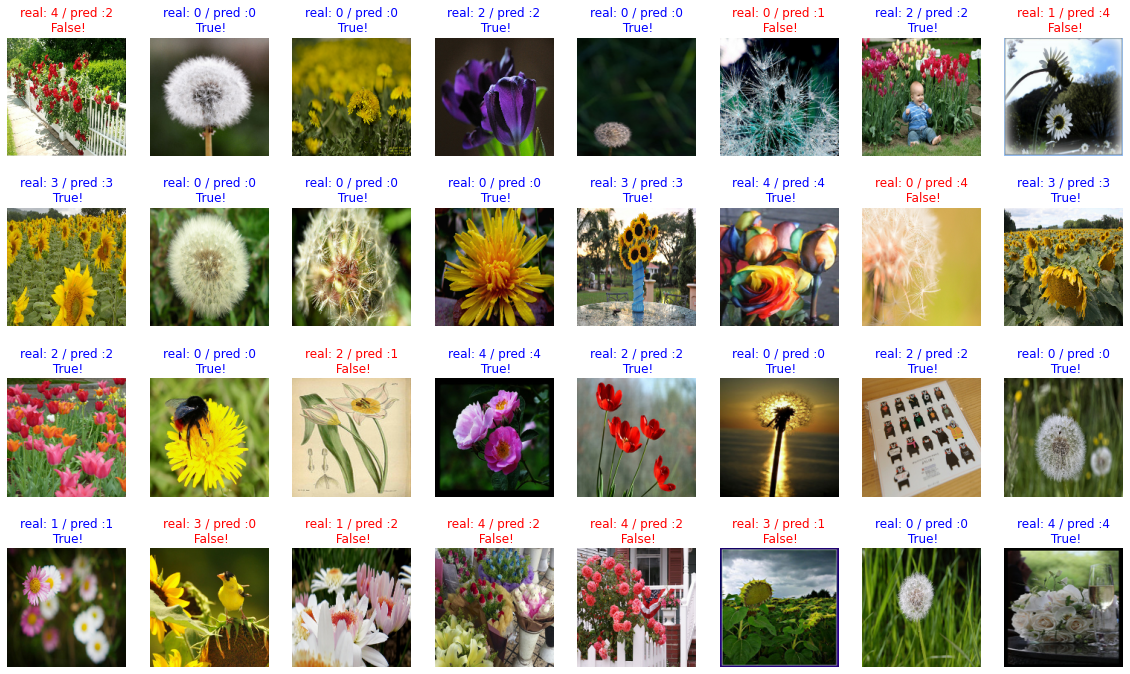

In [24]:
# 예측값과 실제값을 이미지로 확인
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [25]:
# 1개 베치 데이터에 대한 정답률 확인
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count += 1

print(count / 32 * 100)

68.75


In [28]:
# test accuarcy 

model.evaluate(test_batches)

12/12 [==============================] - 0s 14ms/step - loss: 0.8616 - accuracy: 0.7112


[0.8616251349449158, 0.7111716866493225]

In [45]:
del model

# Step 6. Transper learning(VGG16 사용)

## 1) VGG16 로드 및 모델 구성

In [30]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# FC레이어만 직접 설계하므로 include_top=False 설정
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [31]:
# Pooling 레이어를 global average layer로 설정
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [32]:
# Dense 레이어 설정
dense_layer = tf.keras.layers.Dense(512, activation='relu')
dense_layer1 = tf.keras.layers.Dense(64, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [33]:
# 이미 학습된 가중치를 사용할 예정이므로 trainable = False 설정
base_model.trainable = False

In [46]:
# 모델 구성
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    dense_layer1,
    prediction_layer
])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 15,010,501
Trainable params: 295,813
Non-trainable params: 14,714,688
_________________________________________________________________


## 2) 모델 컴파일 및 학습

In [47]:
# 앞에서 설정했던 RMSprop를 Adam으로 변경
base_learning_rate = 0.0001
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']   
)

In [48]:
EPOCHS = 12
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

Epoch 1/12
92/92 [==============================] - 9s 86ms/step - loss: 0.3749 - accuracy: 0.8747 - val_loss: 0.4718 - val_accuracy: 0.8474
Epoch 2/12
92/92 [==============================] - 8s 85ms/step - loss: 0.3613 - accuracy: 0.8835 - val_loss: 0.4730 - val_accuracy: 0.8202
Epoch 3/12
92/92 [==============================] - 8s 88ms/step - loss: 0.3557 - accuracy: 0.8852 - val_loss: 0.4475 - val_accuracy: 0.8529
Epoch 4/12
92/92 [==============================] - 8s 87ms/step - loss: 0.3414 - accuracy: 0.8900 - val_loss: 0.4532 - val_accuracy: 0.8338
Epoch 5/12
92/92 [==============================] - 8s 86ms/step - loss: 0.3313 - accuracy: 0.8951 - val_loss: 0.4464 - val_accuracy: 0.8447
Epoch 6/12
92/92 [==============================] - 8s 85ms/step - loss: 0.3240 - accuracy: 0.8934 - val_loss: 0.4434 - val_accuracy: 0.8392
Epoch 7/12
92/92 [==============================] - 8s 84ms/step - loss: 0.3134 - accuracy: 0.9005 - val_loss: 0.4414 - val_accuracy: 0.8447
Epoch 8/12
92

## 3) 모델 성능 결과 확인

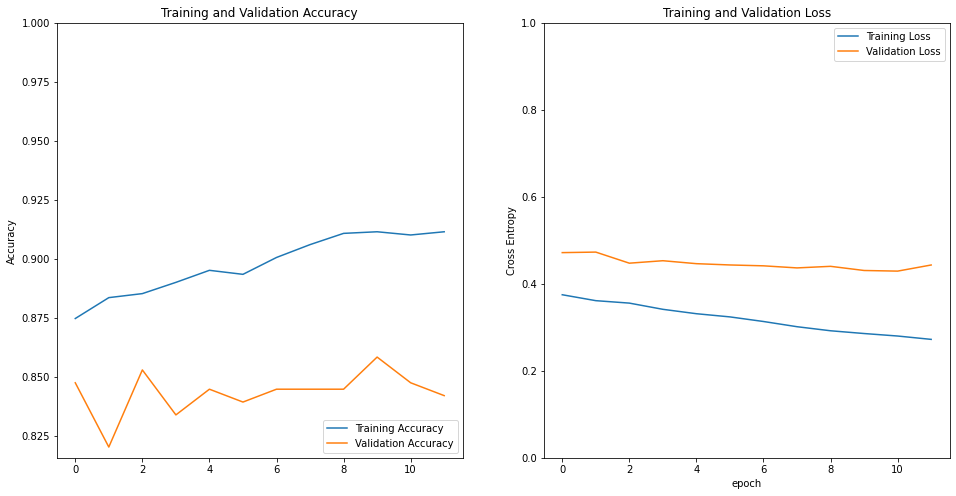

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

array([[4.29143570e-03, 1.52057586e-02, 8.47846687e-01, 6.43991353e-03,
        1.26216069e-01],
       [9.99930978e-01, 6.12588847e-05, 5.16467821e-07, 5.97688143e-07,
        6.72910483e-06],
       [7.54455984e-01, 1.23221256e-01, 5.90980146e-03, 1.02446996e-01,
        1.39660807e-02],
       [1.38282965e-04, 5.99962485e-04, 3.95105034e-01, 3.80586396e-04,
        6.03776097e-01],
       [7.64292955e-01, 2.18814641e-01, 2.71014334e-03, 4.76565538e-03,
        9.41661745e-03],
       [9.78243113e-01, 1.66637711e-02, 4.83089854e-04, 4.45195008e-03,
        1.57997376e-04],
       [3.05438484e-03, 1.39455125e-03, 9.52260554e-01, 1.75785571e-02,
        2.57120598e-02],
       [4.86097336e-01, 5.00798583e-01, 3.03447858e-04, 1.21704275e-02,
        6.30175811e-04],
       [2.56339228e-03, 7.74888395e-05, 4.54863627e-03, 9.79819953e-01,
        1.29904123e-02],
       [9.99870777e-01, 1.26594663e-04, 5.43926149e-07, 9.94417860e-07,
        1.10073813e-06],
       [9.82852399e-01, 1.5812

In [51]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

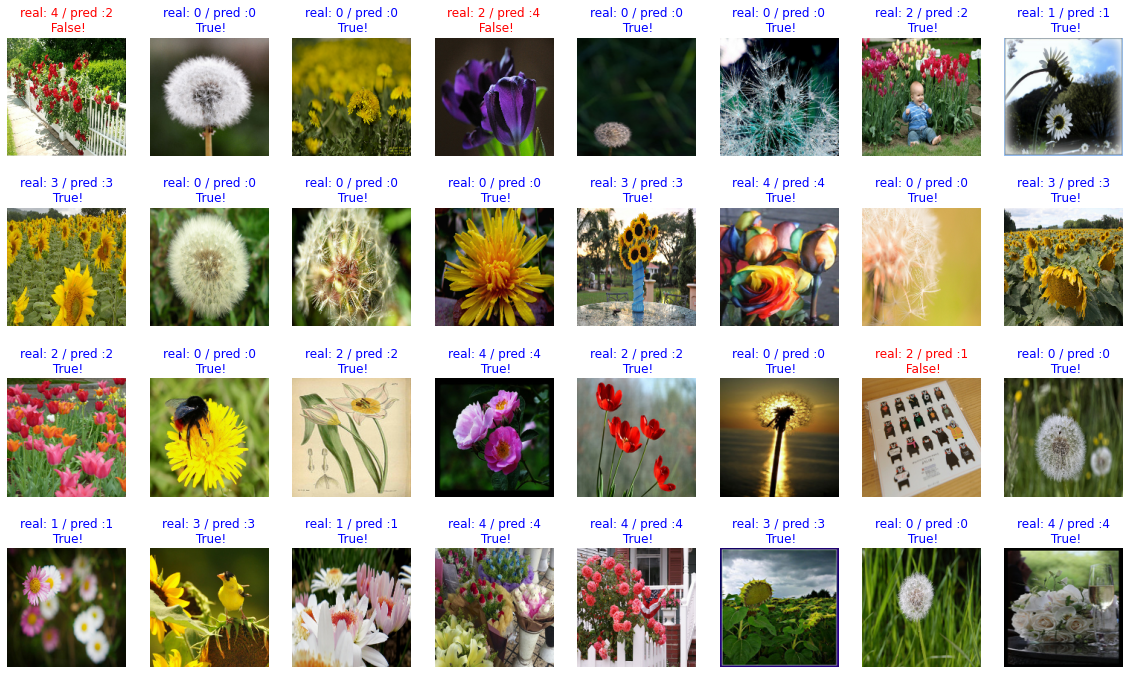

In [52]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [53]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) 

90.625


In [54]:
# test accuarcy 

model.evaluate(test_batches)

12/12 [==============================] - 1s 66ms/step - loss: 0.3996 - accuracy: 0.8556


[0.39959636330604553, 0.8555858135223389]

In [55]:
model.save('flower_model.keras') 

# Step7. 모델 활용(다른 꽃 이미지 분류 확인)

In [56]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [63]:
# 라벨 정보 확인
label_to_name = metadata.features['label'].int2str  # 라벨을 꽃 이름으로 매핑하는 딕셔너리
num_classes = metadata.features['label'].num_classes  # 클래스 개수

# 모든 클래스와 그에 해당하는 꽃 이름 출력
for i in range(num_classes):
    print(f"Label {i} corresponds to {label_to_name(i)}")

Label 0 corresponds to dandelion
Label 1 corresponds to daisy
Label 2 corresponds to tulips
Label 3 corresponds to sunflowers
Label 4 corresponds to roses


In [66]:
# 이미지 변형 및 예측값 확인 함수 작성
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulips_percentage}% tulips, {sunflower_percentage}% Sunflower, and {roses_percentage}% roses.")

This image seems 0% dandelion, 0% daisy, 100% tulips, 0% Sunflower, and 0% roses.


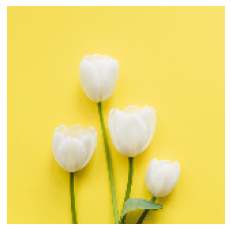

In [67]:
# 튤립 100% 인식
filename = 'tulip.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 0% dandelion, 100% daisy, 0% tulips, 0% Sunflower, and 0% roses.


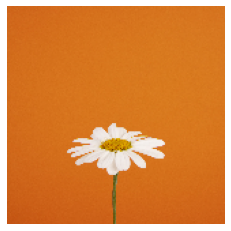

In [68]:
# 데이지 100% 인식
filename = 'daisy.jpg'

show_and_predict_image(img_dir_path, filename)

# 회고

- 모델 구성 및 학습 부분
    - 직접 쌓은 CNN과 VGG16의 성능이 어떻게 다른지 비교하고자 모델 셀계 및 학습을 각각 달리 실시해 봄
    - 당연히 VGG16이 성능이 좋게 나옴. 다음 프로젝트 실시에는 직접 설계한 모델의 성능도 VGG만큼 올릴 수 있게 시도할 예정
    
- 데이터 전처리
    - CV에서는 각 이미지의 크기가 다르기에 데이터 전처리 작업이 중요하다는 것 알았음
    - 데이터 전처리에 필요한 함수 작성 등 해당 부분에 대한 학습을 더 해야 겠다고 생각함